In [1]:
from tensorflow.keras.utils import plot_model
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,\
     Flatten, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.callbacks import *
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


In [4]:
train_images = train_images/255.0
test_images = test_images/255.0

In [5]:
w, h = 28, 28
train_images = train_images.reshape(train_images.shape[0], w, h, 1)
test_images = test_images.reshape(test_images.shape[0], w, h, 1)

In [6]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [8]:
classess = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [9]:
def Structure(X):
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.3)(pool2)
    # conv3 = Conv2D(64, 2, activation='relu', padding='same')(pool2)
    # conv3 = Conv2D(64, 2, activation='relu', padding='same')(conv3)
    # conv3 = Conv2D(64, 2, activation='relu', padding='same')(conv3)
    # pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = MaxPooling2D(pool_size=(2, 2))(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = MaxPooling2D(pool_size=(2, 2))(X)
    # X = UpSampling2D(size=(2, 2))(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)
    # X = Conv2D(128, 3, activation='relu', padding='same')(X)   
    # X = UpSampling2D(size=(2, 2))(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)
    # X = Conv2D(256, 3, activation='relu', padding='same')(X)   
    # up1 = UpSampling2D(size=(2, 2))(pool3)
    # up1 = concatenate([conv3, up1], axis=-1)
    # conv4 = Conv2D(64, 3, activation='relu', padding='same')(up1)
    # conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)
    # conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)   
    # conv4 = Dropout(0.3)(conv4)
    up2 = UpSampling2D(size=(2, 2))(pool2)
    up2 = concatenate([conv2, up2], axis=-1)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.2)(conv5)
    up3 = UpSampling2D(size=(2, 2))(conv5)
    up3 = concatenate([conv1, up3], axis=-1)
    conv6 = Conv2D(16, 3, activation='relu', padding='same')(up3)
    conv6 = Conv2D(16, 3, activation='relu', padding='same')(conv6)
    return conv6

In [10]:
def UNET(input_shape = (w, h, 1), classes = classess):
    X_input = Input(shape = input_shape)
    X = Structure(X_input)
    X = Conv2D(len(classes), 1, activation = 'softmax')(X)
    X = Flatten()(X)
    X = Dense(len(classess), activation='softmax')(X)
    model = Model(inputs = X_input, outputs = X, name = 'U-net')
    return model

In [11]:
#Clear unnecessary memory
from tensorflow.keras import backend as K
import tensorflow as tf
K.clear_session()

In [12]:
model = UNET(input_shape = (w, h, 1), classes = classess)
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
# import os
# import datetime

# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet-mnist.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataUnetmnist.csv"),
    TensorBoard(log_dir='./logs-Unet-MNIST', histogram_freq=1)
]

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_images, 
                    train_labels,
                    batch_size = 256,
                    validation_split=0.15,
                    epochs = 100,
                    shuffle = True,
                    callbacks= callbacks)

Epoch 1/100
200/200 [==============================] - 15s 23ms/step - loss: 0.4985 - accuracy: 0.8405 - val_loss: 0.0991 - val_accuracy: 0.9719

Epoch 00001: val_loss improved from inf to 0.09910, saving model to model-Unet-mnist.h5
Epoch 2/100
200/200 [==============================] - 4s 18ms/step - loss: 0.0958 - accuracy: 0.9712 - val_loss: 0.0643 - val_accuracy: 0.9817

Epoch 00002: val_loss improved from 0.09910 to 0.06431, saving model to model-Unet-mnist.h5
Epoch 3/100
200/200 [==============================] - 4s 18ms/step - loss: 0.0706 - accuracy: 0.9777 - val_loss: 0.0525 - val_accuracy: 0.9856

Epoch 00003: val_loss improved from 0.06431 to 0.05246, saving model to model-Unet-mnist.h5
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 0.0563 - accuracy: 0.9825 - val_loss: 0.0512 - val_accuracy: 0.9851

Epoch 00004: val_loss improved from 0.05246 to 0.05117, saving model to model-Unet-mnist.h5
Epoch 5/100
200/200 [==============================] - 

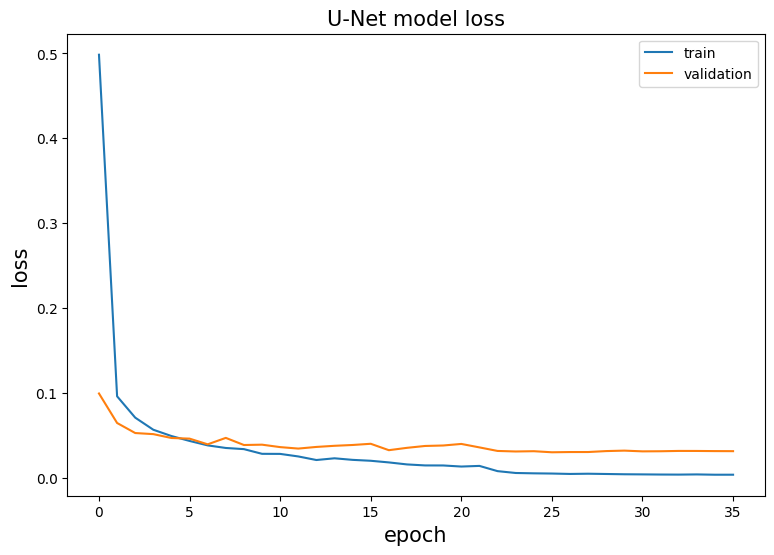

In [16]:
# Loss
plt.figure(figsize = (9, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('U-Net model loss', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.xlabel('epoch', fontsize = 15)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

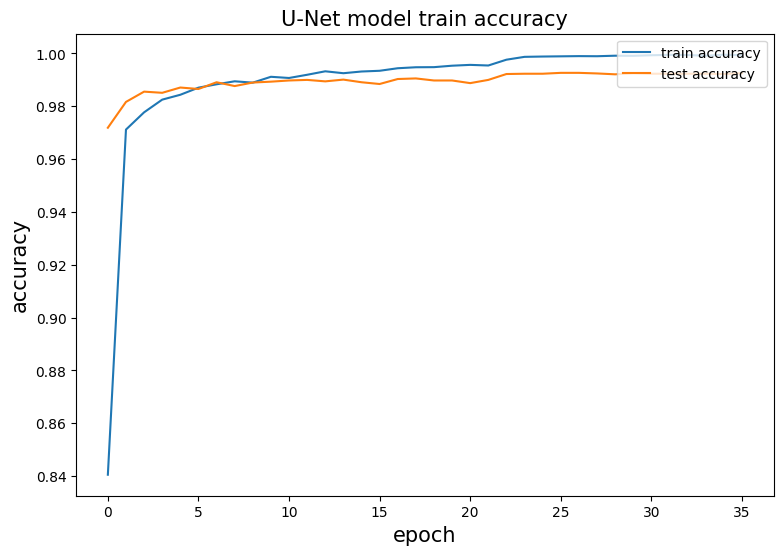

In [17]:
# Accuracy
plt.figure(figsize = (9, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('U-Net model train accuracy', fontsize = 15)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.legend(['train accuracy', 'test accuracy'], loc = 'upper right')
plt.show()

In [18]:
# Evaluating the model using the test set
loss, accuracy = model.evaluate(test_images, test_labels, verbose = 1)
print('\nTest accuracy:', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.0264 - accuracy: 0.9919

Test accuracy: 0.9919000267982483


In [19]:
predictions = model.predict(test_images)

In [20]:
train_images = train_images.reshape(train_images.shape[0], w, h, 1)
test_images = test_images.reshape(test_images.shape[0], w, h, 1)


# Cifar's label need to reshape to scalar array
test_labels = test_labels.reshape(10000, )



# Helper functions to plot images 
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classess[predicted_label],
                                100*np.max(predictions_array),
                                classess[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

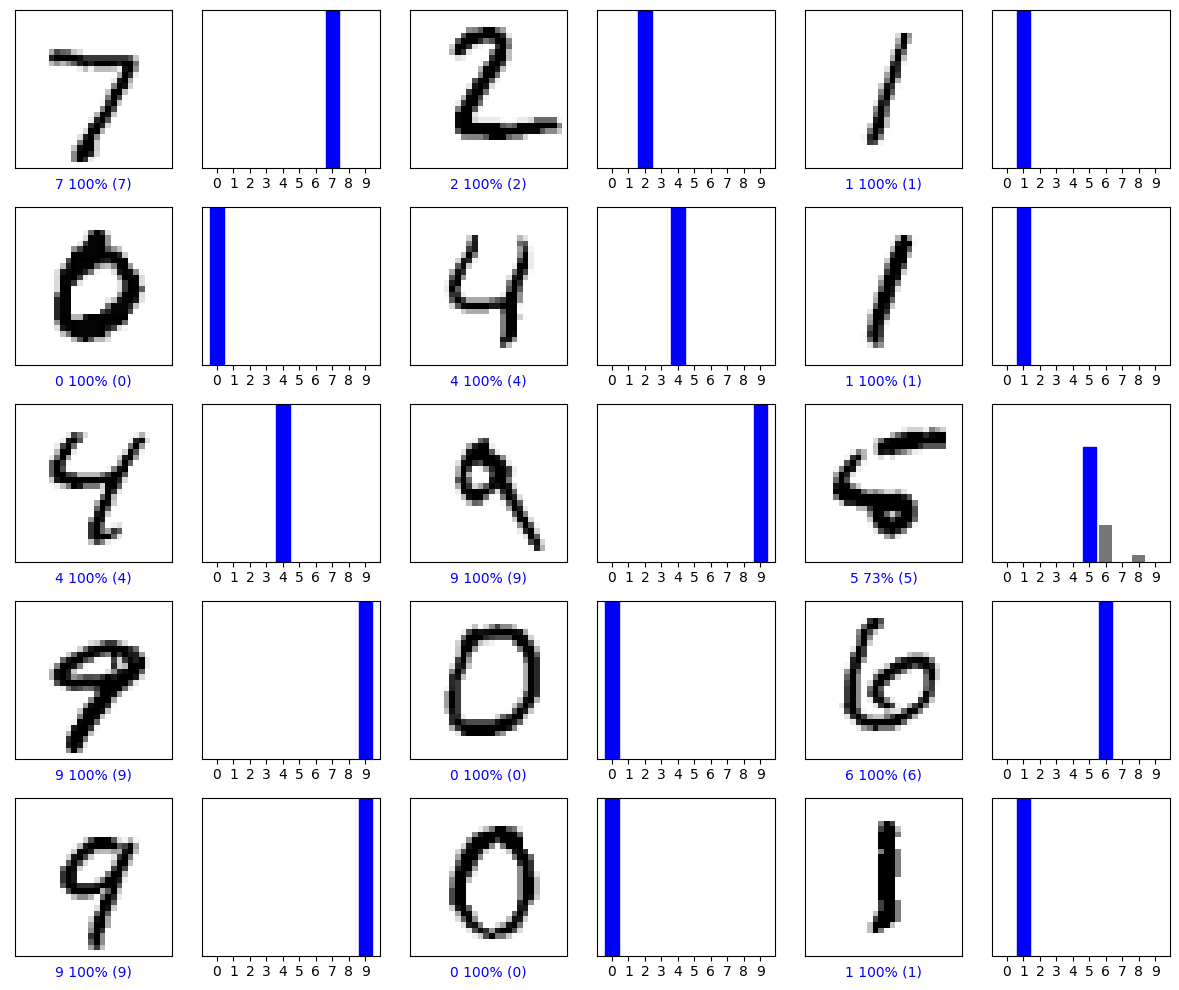

In [21]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()